In [190]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [191]:
#(X_train, y_train), (X_test, y_test) = keras.datasets.california_housing.load_data()

In [192]:
# Load the dataset (e.g., MNIST)
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()


In [193]:
# Reshape the data to 4D tensors (batch_size, height, width, channels)
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

In [194]:
# Normalize the data
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

In [195]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [196]:
# Define the CNN Autoencoder model
model = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(7*7*64, activation='relu'),
    keras.layers.Reshape((7, 7, 64)),
    keras.layers.Conv2DTranspose(64, (3, 3), strides=2, padding='same', activation='relu'),
    keras.layers.Conv2DTranspose(32, (3, 3), strides=2, padding='same', activation='relu'),
    keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')
])

In [197]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [198]:
# Train the model
history = model.fit(X_train, X_train, epochs=10, 
                    validation_data=(X_val, X_val), 
                    verbose=2)


Epoch 1/10
1500/1500 - 71s - 47ms/step - loss: 0.0198 - val_loss: 0.0080
Epoch 2/10
1500/1500 - 67s - 45ms/step - loss: 0.0062 - val_loss: 0.0054
Epoch 3/10
1500/1500 - 64s - 43ms/step - loss: 0.0048 - val_loss: 0.0044
Epoch 4/10
1500/1500 - 80s - 54ms/step - loss: 0.0041 - val_loss: 0.0038
Epoch 5/10
1500/1500 - 67s - 45ms/step - loss: 0.0037 - val_loss: 0.0035
Epoch 6/10
1500/1500 - 70s - 46ms/step - loss: 0.0034 - val_loss: 0.0033
Epoch 7/10
1500/1500 - 73s - 49ms/step - loss: 0.0031 - val_loss: 0.0031
Epoch 8/10
1500/1500 - 77s - 52ms/step - loss: 0.0030 - val_loss: 0.0031
Epoch 9/10
1500/1500 - 76s - 51ms/step - loss: 0.0028 - val_loss: 0.0029
Epoch 10/10
1500/1500 - 65s - 43ms/step - loss: 0.0027 - val_loss: 0.0029


In [199]:
# Evaluate the model on the test set
mse = model.evaluate(X_test, X_test)
print(f'Test MSE: {mse:.3f}')


313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.0028
Test MSE: 0.003


In [200]:
# Use the model to detect anomalies
def detect_anomaly(x, threshold=0.02):
    x_reconstructed = model.predict(x)
    mse = np.mean(np.square(x - x_reconstructed), axis=(1, 2, 3))
    return mse > threshold

In [201]:
# Calculate entropy
def calculate_entropy(labels):
    _, counts = np.unique(labels, return_counts=True)
    probabilities = counts / len(labels)
    entropy = -np.sum(probabilities * np.log2(probabilities))
    return entropy


In [202]:
# Test the anomaly detection function
X_anomaly = X_test[:10]  # select a few test images as anomalies
y_pred = detect_anomaly(X_anomaly)
print(y_pred)  # should output [True, True,..., True] if all are detected as anomalies


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step
[False False False False False False False False False False]


In [203]:
# Visualize the original and reconstructed images
def visualize_reconstructions(original, reconstructed, num_images=9):
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        # Original images
        plt.subplot(3, 3, i + 1)
        plt.imshow(original[i].reshape(28, 28), cmap='gray')
        plt.title(f'Original {i + 1}')
        plt.axis('off')

    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        # Reconstructed images
        plt.subplot(3, 3, i + 1)
        plt.imshow(reconstructed[i].reshape(28, 28), cmap='gray')
        plt.title(f'Reconstructed {i + 1}')
        plt.axis('off')
    plt.show()


In [204]:
reconstructed = model.predict(X_anomaly)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


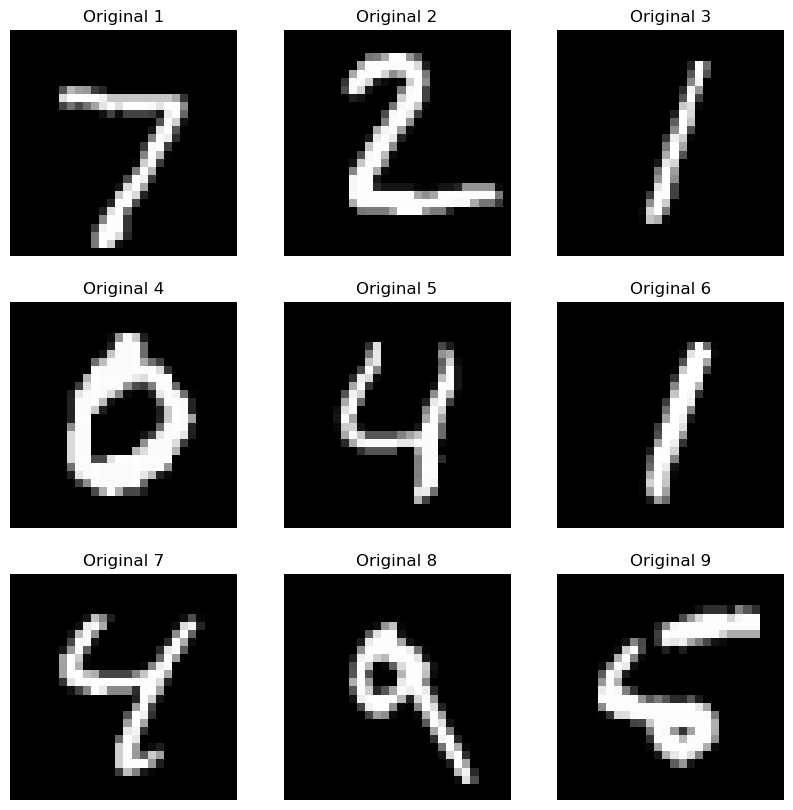

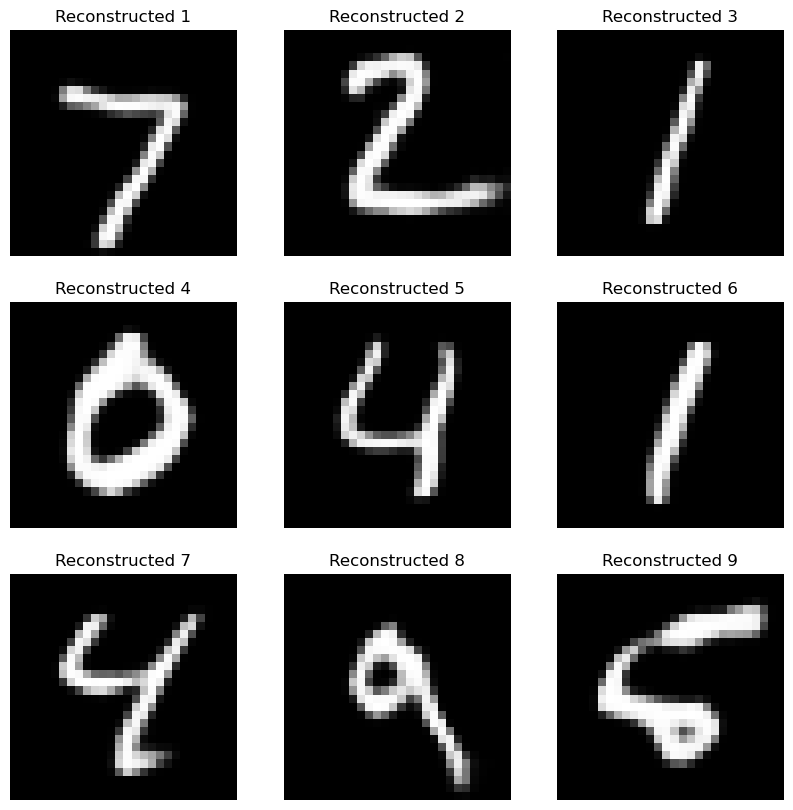

In [205]:
visualize_reconstructions(X_anomaly, reconstructed)

In [206]:
# Use the model to detect anomalies
def calculate_reconstruction_errors(model, data):
    reconstructed_data = model.predict(data)
    reconstruction_errors = np.mean(np.square(data - reconstructed_data), axis=(1, 2, 3))
    return reconstruction_errors

In [207]:
# Calculate reconstruction errors
reconstruction_errors = calculate_reconstruction_errors(model, X_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step


In [208]:
# Set a threshold for anomaly detection (for demonstration, using 95th percentile)
threshold = np.percentile(reconstruction_errors, 95)
simulated_y_pred = reconstruction_errors > threshold

In [209]:
# Calculate entropy before and after thresholding
entropy_before = calculate_entropy(true_labels)
entropy_after = calculate_entropy(simulated_y_pred)


In [210]:
# Calculate information gain
information_gain = entropy_before - entropy_after

In [211]:
# Detect anomalies
y_pred = reconstruction_errors > threshold


In [212]:
# Since we don't have true labels for anomalies in MNIST, we'll simulate some anomalies
# For demonstration, let's assume first 100 are normal (0) and next 100 are anomalies (1)
true_labels = np.array([0] * 100 + [1] * 100)
simulated_data = np.concatenate((X_test[:100], X_test[100:200]))


In [213]:
# Calculate reconstruction errors for simulated data
simulated_reconstruction_errors = calculate_reconstruction_errors(model, simulated_data)
simulated_y_pred = simulated_reconstruction_errors > threshold


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


In [214]:
# Calculate precision, recall, and F1-score
precision = precision_score(true_labels, simulated_y_pred)
recall = recall_score(true_labels, simulated_y_pred)
f1 = f1_score(true_labels, simulated_y_pred)


In [215]:
print(f'Precision: {precision:.3f}')
print(f'Recall: {recall:.3f}')
print(f'F1-Score: {f1:.3f}')
print('\nClassification Report:')
print(classification_report(true_labels, simulated_y_pred))
print(f'Entropy before thresholding: {entropy_before:.3f}')
print(f'Entropy after thresholding: {entropy_after:.3f}')
print(f'Information Gain: {information_gain:.3f}')

Precision: 0.556
Recall: 0.050
F1-Score: 0.092

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.96      0.66       100
           1       0.56      0.05      0.09       100

    accuracy                           0.51       200
   macro avg       0.53      0.51      0.38       200
weighted avg       0.53      0.51      0.38       200

Entropy before thresholding: 1.000
Entropy after thresholding: 0.286
Information Gain: 0.714


In [216]:

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, simulated_y_pred)
print('\nConfusion Matrix:')
print(conf_matrix)



Confusion Matrix:
[[96  4]
 [95  5]]


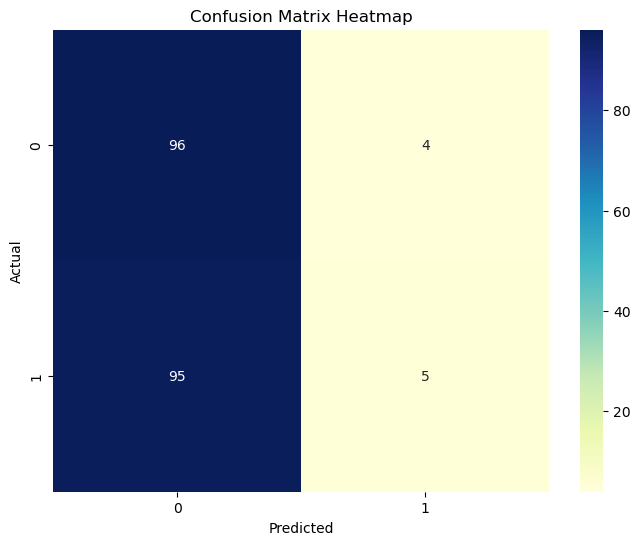

In [217]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap="YlGnBu", fmt="d")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Heatmap')
plt.show()